In [82]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn import preprocessing, neighbors
from sklearn.model_selection import cross_val_score, cross_val_predict
import seaborn as sns
import plotly.plotly as py
import plotly.figure_factory as ff
import warnings
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

music = pd.DataFrame()
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]
music['bpm'] = [ 105, 90, 78, 75, 120, 110, 80, 100, 105, 60,
                  70, 105, 95, 70, 90, 105, 70, 75, 102, 100,
                  100, 95, 90, 80, 90, 80, 100, 105, 70, 65]

# KNN Regression

So far we've introduced KNN as a classifier, meaning it assigns observations to categories or assigns probabilities to the various categories. However, KNN is also a reasonable algorithm for regression. It's a simple extension of what we've learned before and just as easy to implement.

## Everything's the Same

Switching KNN to a regression is a simple process. In our previous models, each of the $k$ oberservations voted for a _category_. As a regression they vote instead for a _value_. Then instead of taking the most popular response, the algorithm averages all of the votes. If you have weights you perform a weighted average.

It's really that simple.

Let's go over a quick example just to confirm your understanding.

Let's stick with the world of music. Instead of trying to classify songs as rock or jazz, lets take the same data with an additional column: beats per minute, or BPM. Can we train our model to predict BPM?

First let's try to predict just in terms of loudness, as this will be easier to represent graphically.

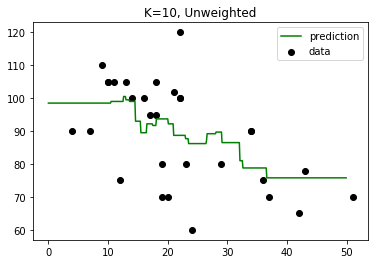

In [6]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

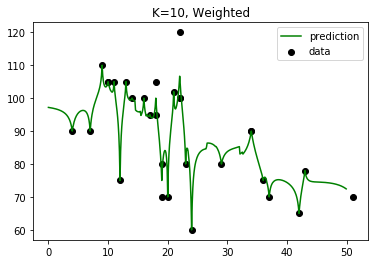

In [7]:
# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn_w.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Weighted')
plt.show()

Notice how it seems like the weighted model grossly overfits to points. It is interesting that it oscillates around the datapoints. This is because the decay in weight happens so quickly.

**Exponentially Weighted Moving Average** (EWMA)


## Validating KNN

Now validating KNN, whether a regression or a classifier, is pretty much exactly the same as evaluating other classifiers or regression. Cross validation is still tremendously valuable. You can do holdouts. You even still get an $R^2$ value for the regression.

Why don't we validate that overfitting of the previous model with some k-fold cross validation? The test statistic given by this model is $R^2$, which measures the same as in linear regression.

In [8]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.18 (+/- 0.66)
Weighted Accuracy: 0.11 (+/- 0.94)


First let me state that these two models are fantastically awful. There doesn't seem to be much of a relationship. It's all very poor. However the increased variance in the weighted model is interesting.

Why don't you add the other feature and mess around with $k$ and weighting to see if you can do any better than we've done so far?

In [81]:
# Run the same model, this time with weights.
knn_uw = neighbors.KNeighborsRegressor(n_neighbors=10, weights='uniform')
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')

X = np.array(music.drop(['bpm'], 1))
y = np.array(music['bpm'])

knn_w.fit(X, y)
knn_uw.fit(X, y)
score = cross_val_score(knn_uw, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.42 (+/- 0.78)
Weighted Accuracy: -0.26 (+/- 0.74)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

In [67]:
# How does scaling the input features affect performance?
# Since the input features are all on different scales, we should rescale them

duration_zscore = scale(music["duration"])
loudness_zscore = scale(music["loudness"])
bpm_zscore = scale(music["bpm"])

knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')


X = np.array([duration_zscore, loudness_zscore]).transpose()
y = bpm_zscore

knn_w.fit(X, y)
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.11 (+/- 0.50)
Weighted Accuracy: -0.11 (+/- 1.05)


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [73]:
knn_w = neighbors.KNeighborsRegressor(n_neighbors=22, weights='distance')

loudness_scaled = music["loudness"] / music["loudness"].max()
duration_scaled = music["duration"] / music["duration"].max()

X = np.array([loudness_scaled.values, duration_scaled.values]).transpose()
y = np.array(music['bpm'])

knn_w.fit(X, y)
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.12 (+/- 0.48)
Weighted Accuracy: -0.13 (+/- 0.67)


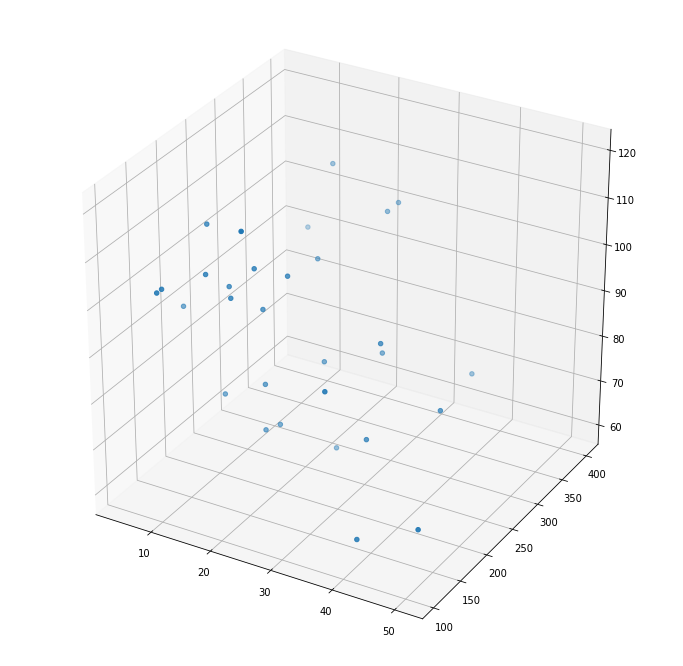

In [96]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(xs = music['loudness'], ys = music['duration'], zs=music['bpm'])

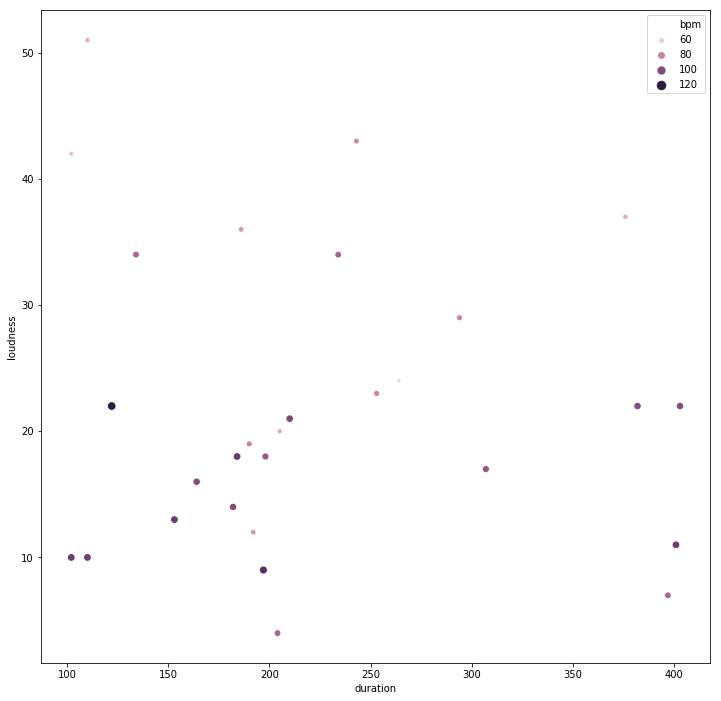

In [102]:
plt.figure(figsize=(12,12))
sns.scatterplot('duration', 'loudness', size='bpm', hue='bpm', data=music)

In [103]:
def perform_knn(k):
    # Build our model.
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    X = np.array(music[['duration','loudness']])
    Y = np.column_stack([music.bpm,music.bpm])
    knn.fit(X, Y)

    # Set up our prediction line.
    T_x1 = np.arange(0, 60, 2)
    T_x2 = np.arange(100, 550, 15)
    T = np.column_stack([T_x1, T_x2])
    # T = np.arange(0, 450, 15)[:, np.newaxis]

    # Trailing underscores are a common convention for a prediction.
    Y_ = knn.predict(T)

    plt.scatter(X, Y, c='k', label='Data')
    plt.plot(T, Y_, c='g', label='Prediction')
    plt.legend()
    plt.title('K={}, Unweighted'.format(k))
    plt.show()

    # Run the same model, this time with weights.
    knn_w = neighbors.KNeighborsRegressor(n_neighbors=14, weights='distance')
    X = np.array(music[['duration','loudness']])
    knn_w.fit(X, Y)

    # Set up our prediction line.
    T_x1 = np.arange(0, 60, 2)
    T_x2 = np.arange(100, 550, 15)
    T = np.column_stack([T_x1, T_x2])

    # Trailing underscores are a common convention for a prediction.
    Y_ = knn_w.predict(T)

    plt.scatter(X, Y, c='k', label='Data')
    plt.plot(T, Y_, c='g', label='Prediction')
    plt.legend()
    plt.title('K={}, Weighted'.format(k))
    plt.show()

    score = cross_val_score(knn, X, Y, cv=5)
    print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
    score_w = cross_val_score(knn_w, X, Y, cv=5)
    print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

In [115]:
X = np.array(music)
dendro = ff.create_dendrogram(X)
dendro['layout'].update({'width':800, 'height':500})
py.iplot(dendro, filename='music_dendrogram')

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



*My basic intuition says k should be at least 8 and at most 16.* 

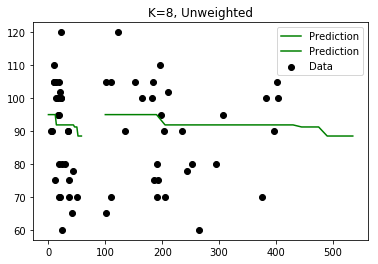

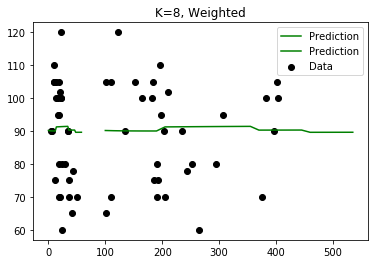

Unweighted Accuracy: -0.49 (+/- 0.79)
Weighted Accuracy: -0.23 (+/- 0.67)


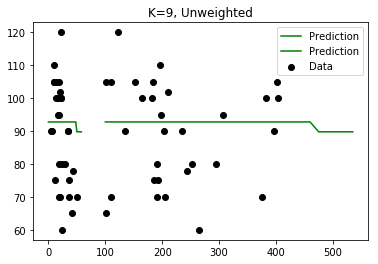

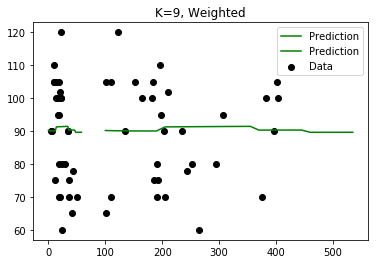

Unweighted Accuracy: -0.42 (+/- 0.60)
Weighted Accuracy: -0.23 (+/- 0.67)


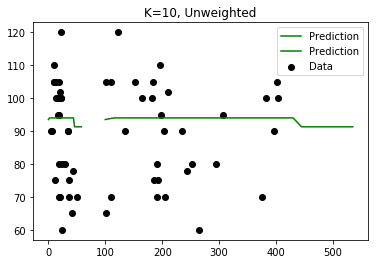

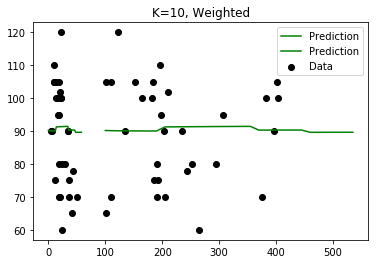

Unweighted Accuracy: -0.42 (+/- 0.78)
Weighted Accuracy: -0.23 (+/- 0.67)


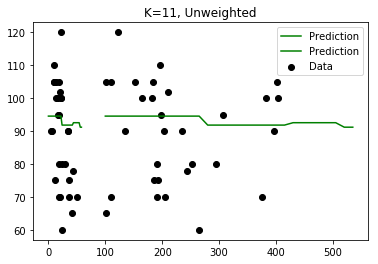

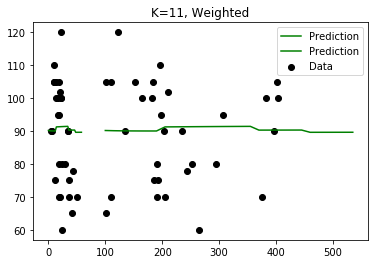

Unweighted Accuracy: -0.38 (+/- 0.73)
Weighted Accuracy: -0.23 (+/- 0.67)


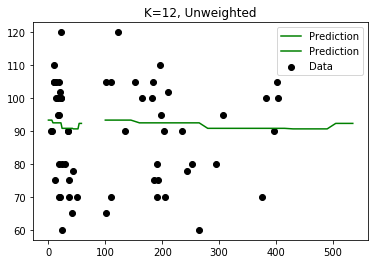

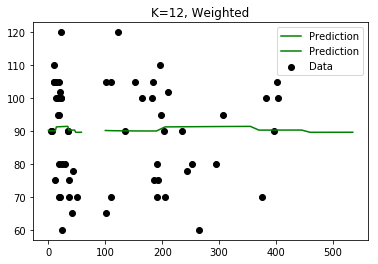

Unweighted Accuracy: -0.38 (+/- 0.63)
Weighted Accuracy: -0.23 (+/- 0.67)


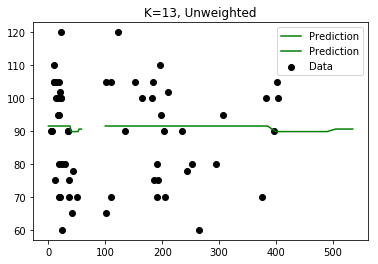

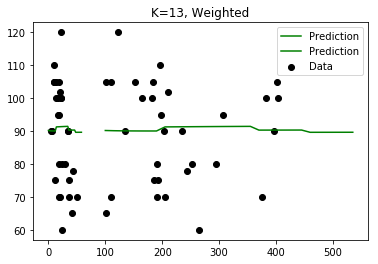

Unweighted Accuracy: -0.38 (+/- 0.73)
Weighted Accuracy: -0.23 (+/- 0.67)


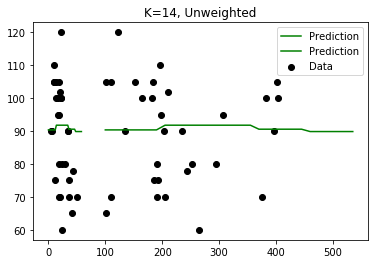

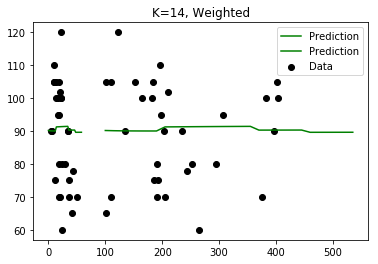

Unweighted Accuracy: -0.34 (+/- 0.75)
Weighted Accuracy: -0.23 (+/- 0.67)


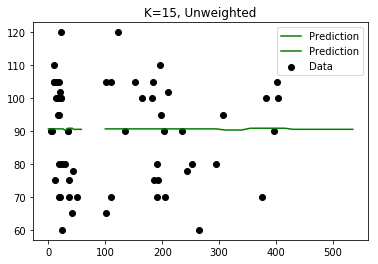

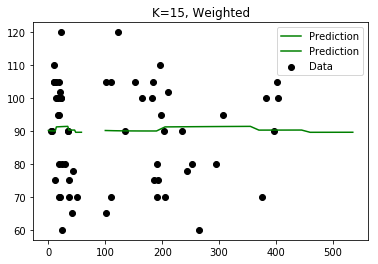

Unweighted Accuracy: -0.38 (+/- 0.65)
Weighted Accuracy: -0.23 (+/- 0.67)


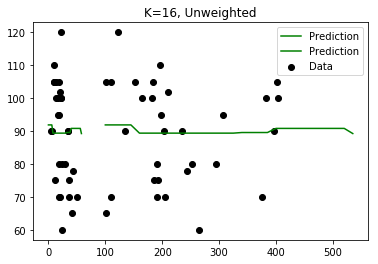

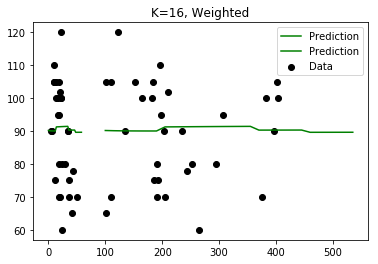

Unweighted Accuracy: -0.32 (+/- 0.52)
Weighted Accuracy: -0.23 (+/- 0.67)


In [116]:
# just do a "brute-force" type analysis for figuring out the best value for k
for k in range(8,17):
    perform_knn(k=k)

In conclusion, yes this model is bad. We see the lowest variance when k is larger than 15, and the variance tends to be higher for unweighted models than weighted; **Optimal k is 14**